## **PyTorch Workflow**


Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

### **1. Data (Preparing & loading)**

In [1]:
# import torch
import torch

# Create known parameters
weight = 0.7
bias = 0.3

# Create 
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [2]:
len(X), len(y)

(50, 50)

**Splitting data into training and testing sets:**

In [4]:
train_split = int(len(X)*0.80)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
import matplotlib.pyplot as plt

def plot_predictions(train_data, train_label, 
                     test_data, test_labels,
                     predictions = None):
    # Figure size
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_label, c = 'b', s = 15, label = 'Training Data')

    # Plot testing data in red 
    plt.scatter(test_data, test_labels, c = 'r', s = 15, label = 'Testing Data')

    # If there is any predictions 
    if predictions is not None:
        # plot predictions data if they exist 
        plt.scatter(test_data, predictions, c = 'g', s = 15, label = 'Predictions')

    plt.legend(prop = {'size': 14})

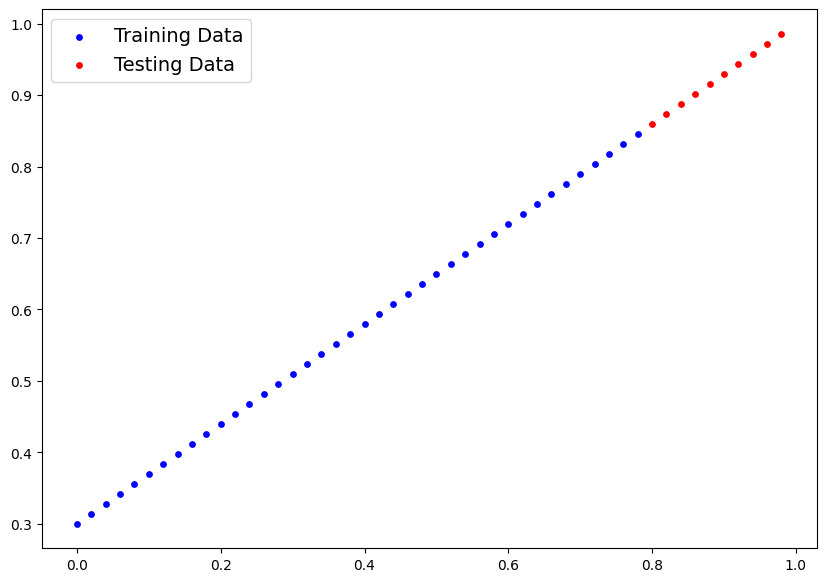

In [7]:
plot_predictions(X_train, y_train, X_test, y_test, None)

### **2. Build Model**

In [11]:
from torch import nn

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(
            1,
            requires_grad = True,
            dtype = torch.float32
        ))
        self.bias = nn.Parameter(torch.randn(
            1, 
            requires_grad = True,
            dtype = torch.float32
        ))
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.weights * x + self.bias

**Checking the contents of our PyTorch Model:**

In [20]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegression()

# Check out the parameters 
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [21]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

**Making predictions using `torch.inference_mode()`**

In [ ]:
# Without inference mode (without training too)
y_preds = model_0(X_test)
y_preds[:5]

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251]], grad_fn=<SliceBackward0>)

In [25]:
# using inference mode
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds[:5], y_test[:5] 


(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160]]))

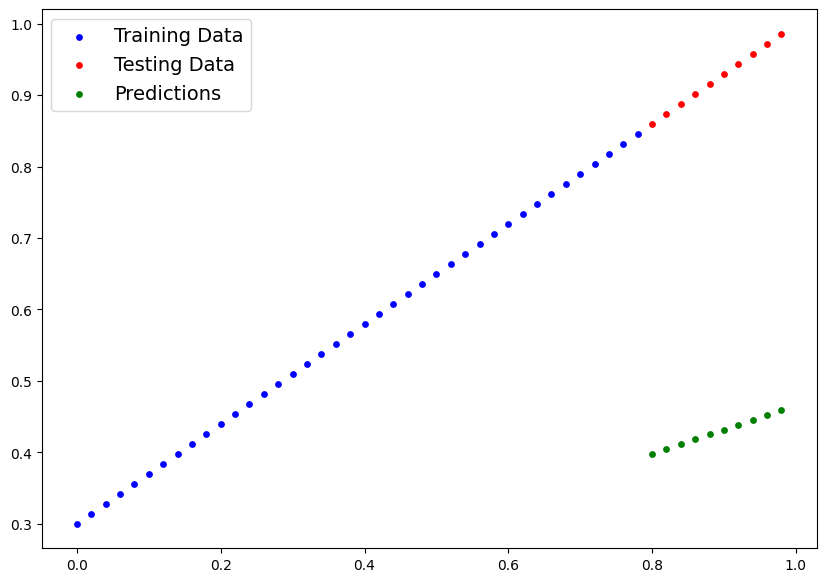

In [26]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

### ***Very bad Model***